In [1]:
import mlflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [ ]:
mlflow_storage_path = "/Users/D065623/Documents/Amna/Time_series_project/mlflow_results/"
mlflow.set_tracking_uri(f'file: {mlflow_storage_path}')

In [4]:
# Set up experiment name. Keep the experiment name the same across all models for easy comparison
mlflow.set_experiment("Demand Forecast Experiment")

<Experiment: artifact_location=('file:///Users/D065623/Documents/Amna/Time_series_project/Notebooks/ '
 '/Users/D065623/Documents/Amna/Time_series_project/mlflow_results/185144220712303128'), creation_time=1750193809093, experiment_id='185144220712303128', last_update_time=1750193809093, lifecycle_stage='active', name='Demand Forecast Experiment', tags={}>

In [5]:
# Start MLFlow UI
from pyngrok import ngrok, conf
import getpass
import subprocess

In [6]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/Use...>

[2025-06-17 23:53:37 +0200] [18117] [INFO] Starting gunicorn 23.0.0
[2025-06-17 23:53:37 +0200] [18117] [INFO] Listening at: http://127.0.0.1:5000 (18117)
[2025-06-17 23:53:37 +0200] [18117] [INFO] Using worker: sync
[2025-06-17 23:53:37 +0200] [18119] [INFO] Booting worker with pid: 18119
[2025-06-17 23:53:37 +0200] [18120] [INFO] Booting worker with pid: 18120
[2025-06-17 23:53:37 +0200] [18121] [INFO] Booting worker with pid: 18121
[2025-06-17 23:53:37 +0200] [18122] [INFO] Booting worker with pid: 18122


In [7]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = '2ySngvaUOk1DjbUMQ1vJd5EpMJs_79kpdbyCMUUGLnhkDKBNj'
#getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
 * ngrok tunnel "https://c4f6-94-199-210-163.ngrok-free.app" 


# Read CSV File

In [8]:
file_path = '/Users/D065623/Documents/Amna/Time_series_project/Data/train_Guayas_final.csv'
df = pd.read_csv(file_path)

In [10]:
df.shape

(9541633, 33)

# Label Encoding

In [11]:
# labelencoding for categorical variables
from sklearn.preprocessing import LabelEncoder
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df
# List of categorical columns to encode
categorical_columns = [ 'store_nbr', 'family', 'item_nbr', 'type', 'locale', 'locale_name', 'description']
# Apply label encoding
df = label_encode(df, categorical_columns)

# XGBoost

In [12]:
split_date = '2014-01-01'
train = df[df['date'] < split_date]
test = df[df['date'] >= split_date]

In [13]:
# Creating Features and Labels


features = ['store_nbr', 'item_nbr', 'onpromotion', 
           'year', 'month', 'day', 'day_of_week',
           'cluster', 'family', 'class', 'perishable', 'type', 'locale', 'locale_name',
           'description', 'transferred', 
           'is_holiday', 'holiday_effect', 'is_weekend',
           'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_30',
           'rolling_mean_2', 'rolling_mean_3', 'unit_sales_7d_avg', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7'] 
labels = 'unit_sales'

In [14]:
# X_train, X_test, y_train, y_test from train, featutes, labels
X_train = train[features]
X_test = test[features]
y_train = train[labels]
y_test = test[labels]

In [15]:
# Implemeting xgboost for time series forecasting

#intializing Model
xgboost_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 100,
    max_depth = 10,
    learning_rate = 0.1,
    enable_categorical=True
)

In [16]:
#Model training xgboost model on training data
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
#Prediction on test data
y_pred = xgboost_model.predict(X_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

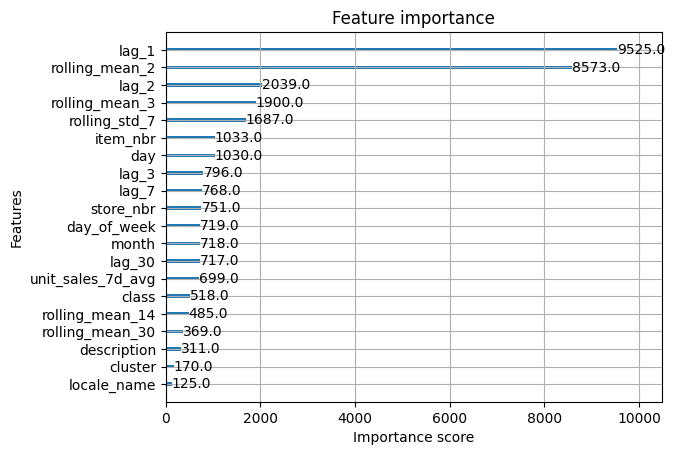

In [18]:
# calculating xgboost feature importance
xgb.plot_importance(xgboost_model, max_num_features=20, importance_type='weight')


In [19]:
#calculating bias, MAD, rMAD
MSE = mean_squared_error(y_test, y_pred)
bias = np.mean(y_pred - y_test.values)
mad = np.mean(np.abs(y_pred - y_test.values))
rmad = mad / np.mean(y_test.values)
print(f"MSE: {MSE}, Bias: {bias}, MAD: {mad}, rMAD: {rmad}")

MSE: 5.693576376132679, Bias: 0.001901129061034757, MAD: 0.11466637524615035, rMAD: 0.046560855050902655


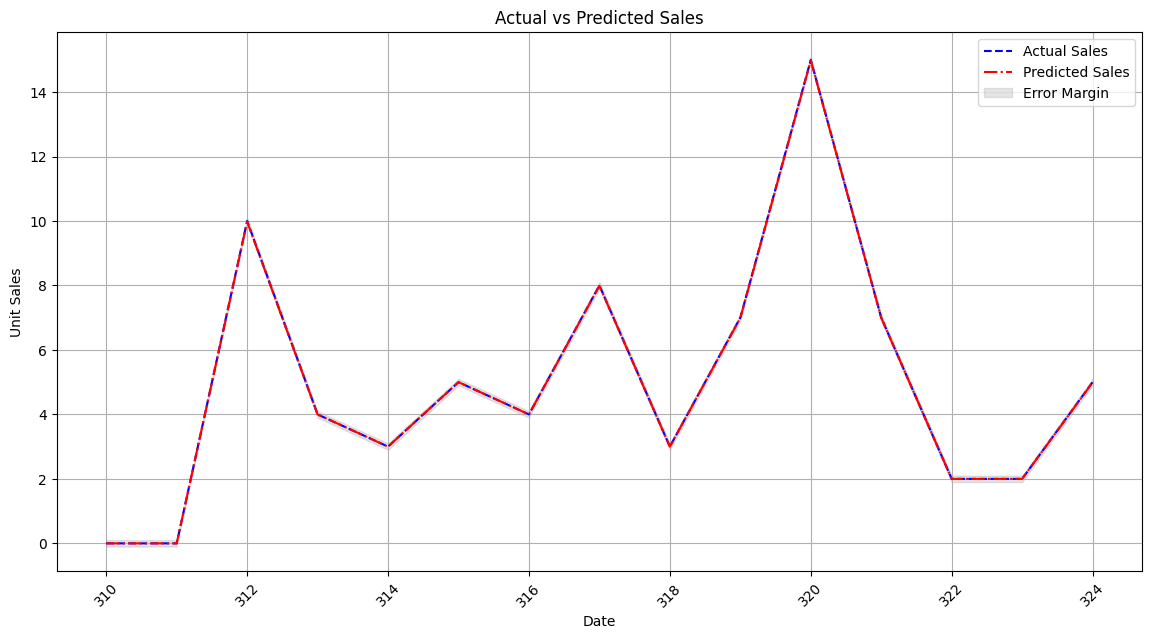

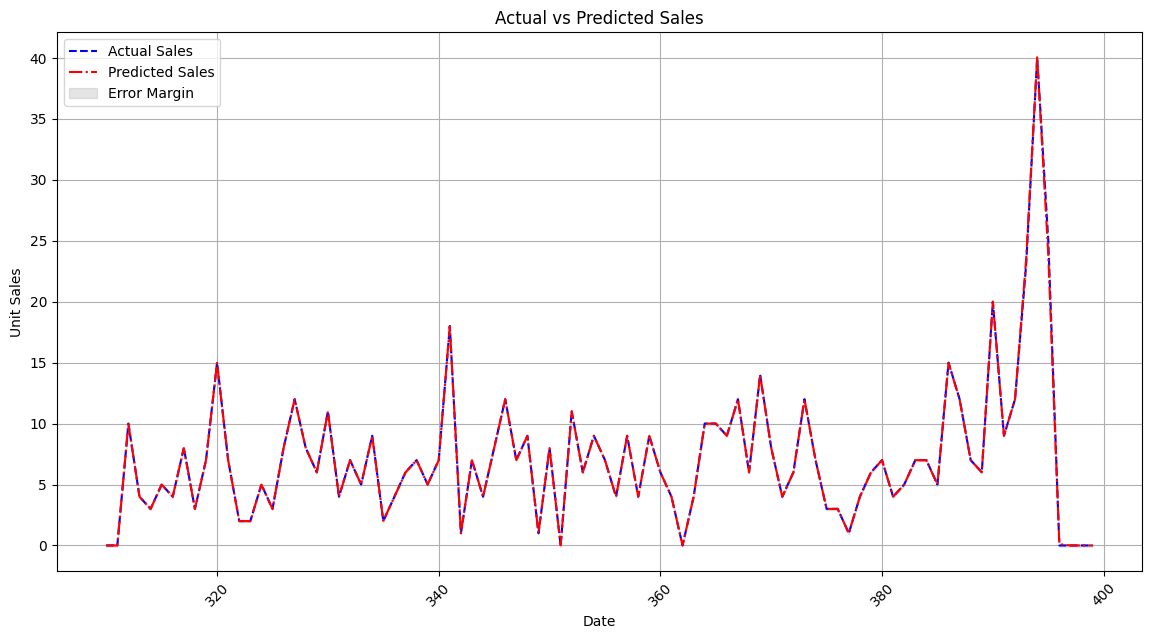

In [26]:
plot_per_test_size = [15, 90]
plot_paths = []
base_path = '/Users/D065623/Documents/Amna/Time_series_project/Models/plots/xgboost_plot_'
#plot_paths = f'/Users/D065623/Documents/Amna/Time_series_project/Models/plot/xgboost_plot_{i}.png'

for i in plot_per_test_size:
    plt.figure(figsize = (14, 7))
    plt.plot(y_test.index[:i], y_test.values[:i], label = 'Actual Sales', color='blue', linestyle='--')
    plt.plot(y_test.index[:i], y_pred[:i].round(2), label = 'Predicted Sales', color='red', linestyle='-.')
    error = y_test.values[:i] - y_pred[:i].round(2)
    plt.fill_between(y_test.index[:i], y_test.values[:i] - 0.1, y_test.values[:i] + 0.1, color='gray', alpha=0.2, label='Error Margin')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.xticks(rotation=45)
    plt.grid()
    f_path = f'{base_path}_{i}.png'
    plt.legend()
    plt.savefig(f_path)
    plt.show()
    plot_paths.append(f_path)

In [27]:
plot_paths

['/Users/D065623/Documents/Amna/Time_series_project/Models/plots/xgboost_plot__15.png',
 '/Users/D065623/Documents/Amna/Time_series_project/Models/plots/xgboost_plot__90.png']

log metrics for xgboost model in mlflow

In [29]:
import mlflow.xgboost
from mlflow.models.signature import infer_signature

In [ ]:
with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 100) #value we used above
    mlflow.log_param("max_depth", 10) #value we used above
    mlflow.log_param("learning_rate", 0.1) #value we used above
    mlflow.log_metric("MSE", MSE) #mean squared error
    mlflow.log_metric("Bias", bias) #mean bias
    mlflow.log_metric("MAD", mad) #mean absolute deviation
    mlflow.log_metric("rMAD", rmad) #relative mean absolute deviation
    
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

Run ID: 01ef89c9012e497f93e3712780ecc39a


2025/06/18 00:22:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[2025-06-18 00:24:10 +0200] [18117] [CRITICAL] WORKER TIMEOUT (pid:18121)
[2025-06-18 00:24:10 +0200] [18121] [ERROR] Error handling request (no URI read)
Traceback (most recent call last):
  File "/opt/miniconda3/envs/py310/lib/python3.10/site-packages/gunicorn/workers/sync.py", line 133, in handle
    req = next(parser)
  File "/opt/miniconda3/envs/py310/lib/python3.10/site-packages/gunicorn/http/parser.py", line 41, in __next__
    self.mesg = self.mesg_class(self.cfg, self.unreader, self.source_addr, self.req_count)
  File "/opt/miniconda3/envs/py310/lib/python3.10/site-packages/gunicorn/http/message.py", line 259, in __init__
    super().__init__(cfg, unreader, peer_addr)
  File "/opt/miniconda3/envs/py310/lib/python3.10/site-packages/gunicorn/http/message.py", line 60, in __init__
    unused = self.parse(self.unreader)
  File "/opt/miniconda3/envs/py310/lib/python3.10/site-packages/gunicorn/http/message.py", line 271, in parse
    self.get_data(unreader, buf, stop=True)
  File "/